In [121]:
%matplotlib inline
from momma_dragonn.data_loaders.hdf5_data_loader import MultimodalAtOnceDataLoader
data_loader = MultimodalAtOnceDataLoader(path_to_hdf5="Ctcf/test_data.hdf5",
                                         bundle_x_and_y_in_generator=False,
                                         strip_enclosing_dictionary=True)
data = data_loader.get_data()

('Input modes', [u'sequence'])
('Output modes', [u'output'])
('num_to_load_for_eval is ', None, 'but num_items is', 14787, '- fixing')


In [122]:
len(data.X)

14787

In [123]:
!ls chr1_Ctcf/

Analyse Score Consistency.ipynb
config
inputs.gz
labels.gz
make_hdf5_yaml
model_files
model_weights.h5
prepSplits.sh
rc
runs_perf-metric-auROC.db
snapshots
splits
subsets
SummarisePerformanceAcrossNumFiltersChr1CTCF.ipynb
test_data.hdf5
train_data.hdf5
valid_data.hdf5


In [124]:

model_load_configs = [
    {"weights": "chr1_Ctcf/model_files/record_95_model_kbaIV_modelWeights.h5",
     "json": "chr1_Ctcf/model_files/record_95_model_kbaIV_modelJson.json",
     "descriptor": "chr1x2 rc-f_nbf-16_ws-f_str-20 seed-0",
     "name": "No RC weight tying, no RC data augmentation"
    },
    {"weights": "chr1_Ctcf/rc/model_files/record_1_model_tdosQ_modelWeights.h5",
     "json": "chr1_Ctcf/rc/model_files/record_1_model_tdosQ_modelJson.json",
     "descriptor": "chr1CtcfAug rc-f_nbf-16_ws-f_str-20 seed-0",
     "name": "No RC weight tying, RC data augmentation"
    },
    {"weights": "chr1_Ctcf/model_files/record_99_model_0UAqF_modelWeights.h5",
     "json": "chr1_Ctcf/model_files/record_99_model_0UAqF_modelJson.json",
     "descriptor": "chr1x2 rc-t_nbf-16_ws-t_symws-f_ircws-t_str-20 seed-0 ",
     "name": "RC weight tying"
    }
#    {'weights': "model_files/record_99_model_0UAqF_modelWeights.h5",
#     'json': "model_files/record_99_model_0UAqF_modelJson.json",
#     'descriptor': "rc-t_nbf-16_ws-t_symws-f_ircws-t_str-20"},
#    {'weights': "model_files/record_95_model_kbaIV_modelWeights.h5",
#     'json': "model_files/record_95_model_kbaIV_modelJson.json",
#     'descriptor': "rc-f_nbf-16_ws-f_str-20"}
]


In [125]:
from deeplift.conversion import keras_conversion as kc
for model_load_config in model_load_configs:
    weights = model_load_config['weights']
    json = model_load_config['json']
    descriptor = model_load_config['descriptor']
    keras_model = kc.load_keras_model(weights=weights,
                                      json=json)
    model_load_config['model'] = keras_model

In [126]:
for model_load_config in model_load_configs:
    print("\n".join(str(x) for x in model_load_config['model'].get_config()))
    print("\n\n\n")

{'class_name': 'Convolution1D', 'config': {'batch_input_shape': (None, 1000, 4), 'W_constraint': None, 'b_constraint': None, 'name': u'convolution1d_1', 'activity_regularizer': None, 'trainable': True, 'filter_length': 15, 'init': 'glorot_uniform', 'bias': True, 'nb_filter': 16, 'input_dtype': u'float32', 'subsample_length': 1, 'border_mode': u'valid', 'input_dim': None, 'b_regularizer': None, 'W_regularizer': None, 'activation': 'linear', 'input_length': None}}
{'class_name': 'BatchNormalization', 'config': {'gamma_regularizer': None, 'name': u'batchnormalization_1', 'epsilon': 0.001, 'trainable': True, 'mode': 0, 'beta_regularizer': None, 'momentum': 0.99, 'axis': -1}}
{'class_name': 'Activation', 'config': {'activation': 'relu', 'trainable': True, 'name': u'activation_1'}}
{'class_name': 'Convolution1D', 'config': {'W_constraint': None, 'b_constraint': None, 'name': u'convolution1d_2', 'activity_regularizer': None, 'trainable': True, 'filter_length': 14, 'init': 'glorot_uniform', 'b

In [127]:
import numpy as np
import matplotlib.pyplot as plt
nregions = 10000

X = np.array(data.X[:nregions])
Y = np.array(data.Y[:nregions])

chr1x2 rc-f_nbf-16_ws-f_str-20 seed-0


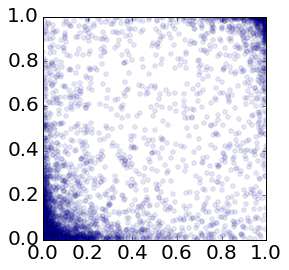

chr1CtcfAug rc-f_nbf-16_ws-f_str-20 seed-0


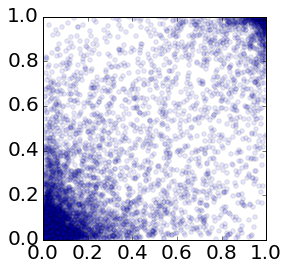

chr1x2 rc-t_nbf-16_ws-t_symws-f_ircws-t_str-20 seed-0 


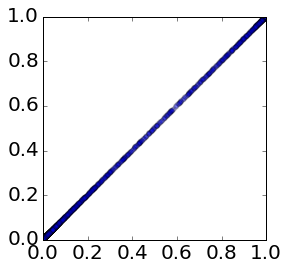

In [128]:
for model_load_config in model_load_configs:
    print(model_load_config['descriptor'])
    keras_model = model_load_config['model']
    fwd_predictions = keras_model.predict(X, batch_size=100)
    rev_predictions = keras_model.predict(X[:,::-1,::-1], batch_size=100)
    
    fwd_prediction_acc = np.sum((fwd_predictions > 0.5)*1 == Y)/float(nregions)
    rev_prediction_acc = np.sum((rev_predictions > 0.5)*1 == Y)/float(nregions)
    
    #print(fwd_prediction_acc)
    #print(rev_prediction_acc)
    
    plt.figure(figsize=(4,4))
    plt.scatter(fwd_predictions, rev_predictions, alpha=0.1)
    plt.xlim(0,1)
    plt.tick_params(labelsize=20)
    #plt.xlabel("Prediction on forward sequence")
    #plt.ylabel("Prediction on reverse complement")
    #plt.title(model_load_config['name'])
    plt.ylim(0,1)
    plt.savefig("scatter "+model_load_config['name'].replace(","," and")+".pdf", format="pdf")
    plt.show()

In [129]:
#load the database records to show difference in perf
records_infos = [
    {'database_path': "chr1_Ctcf/runs_perf-metric-auROC.db",
     'descriptor': "chr1x2 rc-f_nbf-16_ws-f_str-20",
     'name': "No RC model"},
    {'database_path': "chr1_Ctcf/rc/runs_perf-metric-auROC.db",
     'descriptor': "chr1CtcfAug rc-f_nbf-16_ws-f_str-20",
     'name': "No RC model, RC data aug"},
    {'database_path': "chr1_Ctcf/runs_perf-metric-auROC.db",
     'descriptor': "rc-t_nbf-16_ws-t_symws-f_ircws-t_str-20",
     'name': "RC model"},
]

In [130]:
import json
from collections import OrderedDict
grouped_records = OrderedDict()
for records_info in records_infos:
    db_records = json.loads(open(records_info['database_path']).read())['records']
    filtered_records = []
    unique_messages = set()
    for record in db_records:
        message = record['message']
        if records_info['descriptor'] in message:
            if message not in unique_messages: #avoid double-counting runs
                filtered_records.append(record)
                unique_messages.add(message)
    grouped_records[records_info['name']] = filtered_records

In [131]:
auroc_per_group = OrderedDict([(key, [x['best_valid_perf_info']['valid_all_stats']['mean_auROC']
                                      for x in grouped_records[key]]) for key in grouped_records])
auprc_per_group = OrderedDict([(key, [x['best_valid_perf_info']['valid_all_stats']['mean_auPRC']
                                      for x in grouped_records[key]]) for key in grouped_records])

In [132]:
#R has the exact wilcoxon test implemented. So, paste these arrays into R to test p-value. Use one-sided test
for group, groupname in [(auroc_per_group,'auroc'), (auprc_per_group,'auprc')]:
    for key in auroc_per_group:
        keyclean = key.replace(" ","_").replace(",","")+"_"+groupname
        print keyclean, "<-","c("+",".join(str(x) for x in group[key])+")"
    for key1, key2 in zip(auroc_per_group.keys()[:-1], group.keys()[1:]):
        key1 = key1.replace(" ","_").replace(",","")+"_"+groupname
        key2 = key2.replace(" ","_").replace(",","")+"_"+groupname
        print("wilcox.test("+key1+", "+key2+", alternative=\"less\")")

No_RC_model_auroc <- c(0.959226875615,0.957094610766,0.956650182423,0.956269198889,0.956065294426,0.9557605784,0.955668734857,0.954360210215,0.954312990441,0.953215784613)
No_RC_model_RC_data_aug_auroc <- c(0.9663002247,0.965439393076,0.965006312424,0.964429763113,0.964148961808,0.963730139522,0.96356928549,0.963101611093,0.962905061979,0.96069470062)
RC_model_auroc <- c(0.969571290472,0.968523664423,0.968120418172,0.968077643075,0.967809271132,0.96737619048,0.967255672873,0.967203536421,0.966727090671,0.966463753405)
wilcox.test(No_RC_model_auroc, No_RC_model_RC_data_aug_auroc, alternative="less")
wilcox.test(No_RC_model_RC_data_aug_auroc, RC_model_auroc, alternative="less")
No_RC_model_auprc <- c(0.878349327307,0.879318252484,0.877218108927,0.878305718882,0.872747959179,0.869819747037,0.875038684411,0.870063555049,0.873396883183,0.870040395666)
No_RC_model_RC_data_aug_auprc <- c(0.900680652116,0.891827005547,0.897332124731,0.895723101716,0.893760125683,0.893363594054,0.891907877403,0

(0.17499999999999999, 0.96243955066520492)
(1.175, 0.96609273080586988)


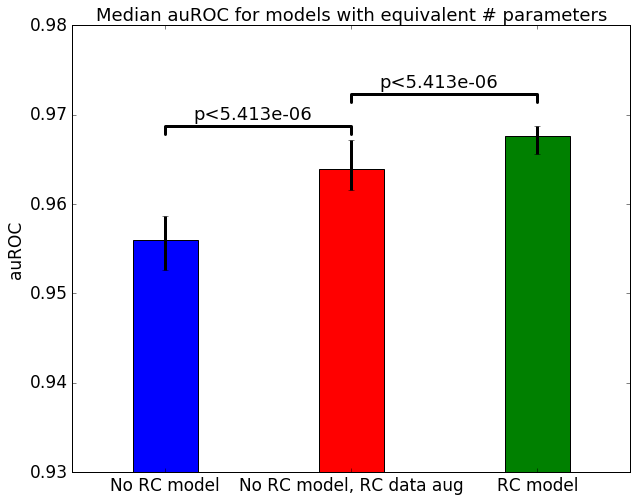

(0.17499999999999999, 0.88851583149322932)
(1.175, 0.90156064335055153)


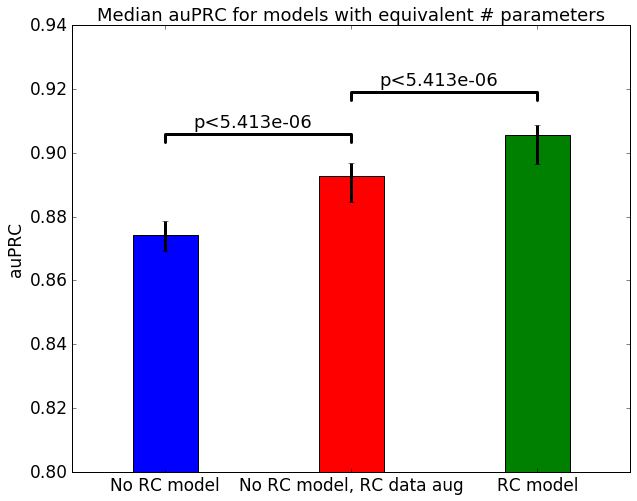

In [119]:
def label_diff(i,j,text,X,Y,yrange):
    x = (X[i]+X[j])/2
    y = 1.0*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    y = y - 0.03*yrange
    
    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':48,'shrinkB':48,'lw':3}
    ax.annotate(text, xy=(x-0.35,y+yrange*0.14), zorder=10, fontsize=18)
    print((X[i],y+0.0))
    ax.annotate('', xy=(X[i],y+0.0), xytext=(X[j],y), arrowprops=props)

for group_stats, stats_name, ymin, ymax in [(auroc_per_group, 'auROC', 0.93, 0.98), (auprc_per_group, 'auPRC', 0.8, 0.94)]:

    N = 3
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars
    fig, ax = plt.subplots(figsize=(10,8))

    X = ind+width/2
    
    all_rects = []
    
    
    keys = list(group_stats.keys())[::-1]
    
    for series_idx, (series, colors) in enumerate([(keys, ('b','r','g'))]):
        median = np.array([np.median(group_stats[x]) for x in series])
        upper_error = np.array([np.max(group_stats[x]) for x in series]) - median
        lower_error = np.abs(np.array([np.min(group_stats[x]) for x in series]) - median)
        rects = ax.bar(ind + width*series_idx, median, width, color=colors, yerr=[upper_error, lower_error], ecolor='k', error_kw={'elinewidth':3})
        all_rects.append(rects)
        
    # add some text for labels, title and axes ticks
    ax.set_ylabel(stats_name, fontsize=17)
    ax.set_ylim(ymin,ymax)
    ax.set_title("Median "+stats_name+" for models with 16 filters each", fontsize=18)
    ax.set_xticks(ind + width / 2.0)
    ax.set_xticklabels(keys, fontsize=17)
    ax.set_xlim(np.min(X)-.5, np.max(X)+.5)
#    ax.legend((all_rects[0][0]), ('without-rc', 'with-rc'), loc=0)
    plt.tick_params(labelsize=17)
    label_diff(0,1,'p<5.413e-06',X,median,ymax-ymin)
    label_diff(1,2,'p<5.413e-06',X,median,ymax-ymin)
    plt.savefig("performanceAcrossNumFiltersAndTFs.pdf", format="pdf")
    plt.show()


In [ ]:
import theano
import keras.backend as K
layer9_out = theano.function([keras_model.input, K.learning_phase()],
                             keras_model.layers[9].output, allow_input_downcast=True)
layer10_out = theano.function([keras_model.input, K.learning_phase()],
                             keras_model.layers[10].output, allow_input_downcast=True)
layerm2_out = theano.function([keras_model.input, K.learning_phase()],
                             keras_model.layers[-2].output, allow_input_downcast=True)

In [ ]:
import numpy as np
random_input = np.random.random((1,1000,4))

In [ ]:
print(np.max(np.abs(layer9_out(random_input, False) - layer9_out(random_input[:, ::-1, ::-1], False)[:,::-1,::-1])))
print(layer10_out(random_input, False))
print(layer10_out(random_input[:,::-1,::-1], False))
print(layerm2_out(random_input, False))
print(layerm2_out(random_input[:,::-1,::-1], False))

In [ ]:
import numpy as np
random_inp = np.random.random((10,1000,4))
print(keras_model.predict(random_inp))
print(keras_model.predict(random_inp[:, ::-1, ::-1]))
print(keras_model.predict(random_inp) - keras_model.predict(random_inp[:, ::-1, ::-1]))

In [ ]:
print(descriptor)

In [ ]:
#compute grad*input importance scores
import theano
from keras import backend as K
import numpy as np
=

In [ ]:
fwd_scores = score_func(random_inp, False)

In [ ]:
rev_scores = score_func(random_inp[:,::-1,::-1], False)

In [ ]:
fwd_scores

In [ ]:
rev_scores